# DSC 200 Final project

This project involves the analysis of a climate projection of temperature change across the Earth under a 'middle-of-the-road' future scenario in which global mean temperatures reach more than 2 degress centigrade above the pre-industrial. You will read in the data, analyze it, and visualize it in a variety of ways. You will also write a small command line interface to make the analysis more interactive. 

We will be using data created by the NorESM2 climate model and processed and as part of the ClimateBench [dataset](https://zenodo.org/records/7064308), described in this [paper](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021MS002954). **All the files you will need for this project are available in the `public` folder on DataHub though.**

### Table of contents:

 1. [Read in CO2 emissions data for historical + future scenario](#1.-Read-in-historical-and-future-(estimated)-CO2-emissions-data) [5 points]
 2. [Read in temperature data](#2.-Read-in-the-temperature-data) [5 points]
 3. [Create a simple regression model](#3.-Create-a-simple-regression-model-of-global-warming) [15 points]
 4. [Extend this to a regional temperature model, by region, and by state](#4.-Extend-this-to-a-regional-temperature-model,-by-region,-and-by-state) [15 points]
 5. [Plot the regression coefficients for each country](#5.-Plot-the-regression-coefficients-for-each-country) [5 points]
 6. [Do an analysis of your choosing](#6.-Do-an-analysis-of-your-choosing) [15 points]
 7. [Make a command line interface](#7.-Make-a-command-line-interface-to-a-prediction-script) [20 points]
 
### Other requirements:
 You will also be graded on Documentation and commenting, coding sytle, and code quality:
 - Documentation should be in the form of a Jupyter notebook, and should include a description of the data, the analysis, and the results. [10 points]
 - The code should be well documented, and should follow the PEP8 coding style. [5 points]
 - The code should be well organized, and should be broken up into functions and classes as appropriate. For full marks try to use no for-loops in your code. [5 points]

Be sure to read the question and reach out to the instructor or TA if you have any questions.

### Total points: 100 (30% of total), plus midterm makeup
 - Note, the midterm grade is still capped at 100%

### Deadline: Sunday December 10th 11:59pm


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## 1. Read in historical and future (estimated) CO2 emissions data

Monthly CO2 emissions data is available since 1850 globally for each industrial sector. We want to use annual average totals of the emissions for all sectors for our analysis. Since CO2 has a very long lifetime in the atmosphere (1000's of years), we can assume that the total amount of anthropogenic CO2 in the atmosphere is the cumulative sum of all emissions since 1850. This is what we will use for our analysis.

To read this data do **either** Q1a (to get 5 points plus additional makup points for the midterm) **or** Q1b (to get 5 points for this project)

In [2]:
input_path = 'public/'

### 1a. OPTIONAL: Create interpolated cumalitve CO2 from the raw data using Pandas

To gain (up to) 50% additional marks for your midterm makeup (capped at 100%), you can create a new column in the CO2 emissions data that is the cumulative CO2 emissions. 

In [3]:
# These input files provide CO2 emissions data for the historical period (1850-2014) and the future period (2015-2100). They should all be concatenated into a single file.

historical_input_files = ['CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_200001-201412.csv',
                          'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_195001-199912.csv',
                          'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_190001-194912.csv',
                          'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_185101-189912.csv']

future_input_file = 'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.csv'

First you will need to read, concatenate and process the raw CSV files, and sum over the `sector` and `month` columns to get an annual total.

In [4]:
# Read the input files

#define an empty list df and we append all the data that has to be read
df = []

#use forloop to read all datasets in hisorical_input_files list
for file in historical_input_files:
    x = pd.read_csv(file)
    df.append(x)

#concatenation process on df
historical_data = pd.concat(df, ignore_index=True)

#reading the future_input_file
future_data = pd.read_csv(future_input_file)

#concatinating future_data and historical_data to get overall data
final_data = pd.concat([historical_data, future_data], ignore_index=True)
final_data

,year,em,sector,month,global_total,units
0,2000,CO2,AGR,1,0.000000,kt
1,2000,CO2,AGR,2,0.000000,kt
2,2000,CO2,AGR,3,0.000000,kt
3,2000,CO2,AGR,4,0.000000,kt
4,2000,CO2,AGR,5,0.000000,kt
...,...,...,...,...,...,...
16819,2100,CO2,NEGCO2,8,-294009.504929,kt
16820,2100,CO2,NEGCO2,9,-284525.327351,kt
16821,2100,CO2,NEGCO2,10,-294009.504929,kt
16822,2100,CO2,NEGCO2,11,-284525.327351,kt


**Note**, the future data is only provided every five years so that will need linearly intepolated to get annual values.

In [5]:
#groupby function to display all the years in dataset and sum of the global_total
df = final_data.groupby('year')['global_total'].sum().reset_index()

#since there are missing values for many years in the future dataset. We need to add the misssing value and NaN for the global_total corresponding to the years

#creating a different dataframe which contains all the years from 1850(min) to 2100(max)
df.set_index('year', inplace=True)

#after setting the year to index we can easily use max() and min() to find the min and max year in our dataset and add it to new dataframe
min_year = df.index.min()
max_year = df.index.max()
int_data = pd.DataFrame({'year': range(min_year, max_year + 1)})

#we merge (left join on year) both the dataframes to finally get the desirable dataframe.
df = pd.merge(int_data, df, how='left', left_on='year', right_index=True)

#linear interpolation
df = df.interpolate(method="linear")
df

,year,global_total
0,1851,1.889473e+05
1,1852,1.965696e+05
2,1853,2.050344e+05
3,1854,2.414711e+05
4,1855,2.439077e+05
...,...,...
245,2096,1.493869e+07
246,2097,1.434807e+07
247,2098,1.375745e+07
248,2099,1.316683e+07


Now, divide by 1e6 to get the units in GtC (Giga tonnes of carbon) and calculate the cumulative sum.

In [6]:
#performing the required and operation and calculating the cumulative sum
df['global_total_GTC'] = df['global_total']/1e6
df['cumulative_global_total'] = df['global_total_GTC'].cumsum()

#cleaning the dataframe
df = df.drop(columns = ['global_total', 'global_total_GTC'])

#saving this in csv for rest of the project
df.to_csv('combinedcumulative_CO2.csv', index = False)

In [7]:
df

,year,cumulative_global_total
0,1851,0.188947
1,1852,0.385517
2,1853,0.590551
3,1854,0.832022
4,1855,1.075930
...,...,...
245,2096,4302.526561
246,2097,4316.874630
247,2098,4330.632079
248,2099,4343.798907


Check the data against the existing `combined_co2.csv` and save it to use for the rest of the project.

### 1b. Otherwise just read in the cumulative CO2 emissions data from the provided file

In [8]:
pre_processed_input_file = 'cumulative_co2.csv'

# Read the input files
pf = pd.read_csv(pre_processed_input_file)
pf

,year,cumulative_CO2
0,1851,0.188947
1,1852,0.385517
2,1853,0.590551
3,1854,0.832022
4,1855,1.075930
...,...,...
245,2096,4302.526561
246,2097,4316.874630
247,2098,4330.632079
248,2099,4343.798907


## 2. Read in the temperature data

Note, this temperature change as modelled by the NorESM2 climate model relative to the pre-industrial period. It's purely driven by the prescribed emissions, so it won't perfect represent the actual temperatures we experienced in a given year (which are subject to chaotic fluctuations), but it's a good model.

In [9]:
# Read the input files
temperture_input_file = 'global_temparature.nc'
temperature_data = xr.open_dataset(temperture_input_file)
temperature_data
## Note, the variable name in the netcdf file is 'tas' (not 'temperature')

<xarray.Dataset>
Dimensions:   (time: 250, lat: 96, lon: 144)
Coordinates:
  * time      (time) int64 1851 1852 1853 1854 1855 ... 2096 2097 2098 2099 2100
  * lat       (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    quantile  float64 ...
Data variables:
    tas       (time, lat, lon) float32 ...

And take the global mean. Don't forget to calculate and include weights for the latitude of each grid cell.

In [10]:
#Converting latitude values from degree to radians
weight = np.cos(np.radians(temperature_data.lat))

#normalising weights
weight /= weight.sum()

#global_mean_temperature considering the latitude based weights
global_mean_temperature = temperature_data['tas'].weighted(weight).mean(dim=['lat', 'lon'])
global_mean_temperature

<xarray.DataArray 'tas' (time: 250)>
array([ 6.72612374e-02,  1.20035238e-01,  1.92815950e-01,  1.95746039e-01,
        8.08993653e-02,  1.72920985e-01,  2.25773570e-01,  1.69944321e-01,
        6.61424517e-02,  5.21966283e-02,  3.33512396e-02,  7.67547077e-02,
        1.19199507e-01,  2.22590415e-01,  7.06020892e-02, -3.75847833e-04,
        3.97141062e-02,  3.24739600e-01,  2.71118462e-01,  9.36015088e-02,
        5.82252315e-02,  9.86642965e-02,  1.13780169e-01,  6.34739321e-02,
        1.47293307e-01,  1.97818004e-01,  2.85449916e-01,  2.01916945e-01,
        6.62375962e-02,  7.17937239e-02,  1.16519847e-01,  1.18019980e-01,
        1.85678850e-01, -1.52653921e-01,  2.00849461e-02,  6.03316979e-02,
        3.63532523e-02, -6.34130996e-02, -3.71111798e-02,  1.73577156e-01,
        4.02010862e-02, -2.47804956e-02, -1.10920204e-02,  1.49081092e-01,
        1.71308035e-01,  1.04495198e-01,  1.67197942e-01,  1.59396502e-01,
        1.59392914e-01,  1.61038228e-01,  1.31962074e-01,  5.44117564e-03,
       -5.49537461e-02,  4.08114067e-02,  3.14748688e-02,  1.01366049e-01,
        1.83650116e-02,  7.37897515e-02,  2.18975589e-01,  5.29528008e-02,
       -5.51062532e-03, -3.91623960e-02, -1.71177998e-02, -1.17959140e-01,
        3.20987506e-02,  5.74513159e-02, -1.84329588e-02,  9.96872244e-02,
        2.49975685e-01,  2.94183267e-01,  1.95579886e-01,  2.82491804e-01,
        3.19973584e-01,  2.84841497e-01,  3.06335213e-01,  1.99241003e-01,
        3.01548520e-01,  3.49974037e-01,  2.94750302e-01,  2.78432015e-01,
...
        9.00831240e-01,  8.45252087e-01,  9.02879005e-01,  9.36569244e-01,
        9.60462383e-01,  1.07070667e+00,  1.11076983e+00,  1.03452646e+00,
        1.01761192e+00,  1.14364759e+00,  1.07994920e+00,  1.11884070e+00,
        1.18613664e+00,  1.16338594e+00,  1.29047341e+00,  1.42639843e+00,
        1.30764482e+00,  1.23807414e+00,  1.13020370e+00,  1.29443518e+00,
        1.54668998e+00,  1.50085058e+00,  1.34577803e+00,  1.33297494e+00,
        1.40430999e+00,  1.40757833e+00,  1.42872005e+00,  1.40285110e+00,
        1.54269582e+00,  1.66138098e+00,  1.56378022e+00,  1.39987839e+00,
        1.39758879e+00,  1.48157894e+00,  1.66829836e+00,  1.60636213e+00,
        1.62231252e+00,  1.71460917e+00,  1.65752638e+00,  1.64908420e+00,
        1.71204971e+00,  1.76603396e+00,  1.71172225e+00,  1.80854068e+00,
        1.95412314e+00,  1.87063017e+00,  1.83833707e+00,  1.76695209e+00,
        1.80987820e+00,  1.89355241e+00,  1.92653268e+00,  1.97297582e+00,
        1.98228104e+00,  1.91828613e+00,  1.79187373e+00,  1.86555629e+00,
        1.81606824e+00,  1.78737220e+00,  2.03393064e+00,  2.09874396e+00,
        1.90060659e+00,  1.94876167e+00,  2.14332166e+00,  2.12103312e+00,
        2.04069285e+00,  2.02418831e+00,  2.07208779e+00,  2.19144215e+00,
        2.23078161e+00,  2.04971392e+00,  2.07181918e+00,  2.12204225e+00,
        2.11252537e+00,  2.00896052e+00,  2.02257726e+00,  2.18747148e+00,
        2.14751340e+00,  2.16579821e+00])
Coordinates:
  * time      (time) int64 1851 1852 1853 1854 1855 ... 2096 2097 2098 2099 2100
    quantile  float64 0.9

## 3. Create a simple regression model of global warming

Global warming can be surprisingly well predicted just using a linear model of cumulative CO2 emissions. This is because the CO2 emissions are the primary driver of global warming, and the CO2 stays in the atmosphere for a long time (see e.g. https://www.nature.com/articles/ngeo3031).

To get global temperature as a function of cumaltive CO2. You can use the `LinearRegression` class from `sklearn.linear_model`, with documentation provided [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). You should only need to use the `fit` and `predict` methods. The `fit` method takes two arguments, the first is the input data, and the second is the output data. The `predict` method takes one argument, the input data.

Alternatively, you can also use the `statsmodels` package to get more detailed statistics on the regression. See [here](https://www.statsmodels.org/stable/regression.html) for documentation.

Since we're only aiming to create an interpolation model, we don't need to worry too much about keeping a test set aside. We can just use all the data to train the model. You could also use a train-test split if you want to.

In [11]:
from sklearn.linear_model import LinearRegression

Plot gobal mean temperature as a function of cumalative CO2 emissions, along with the regression fit


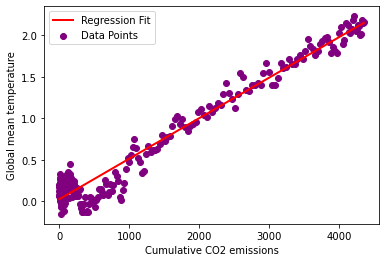

In [12]:
X = df['cumulative_global_total'].values.reshape(-1,1)
y = global_mean_temperature.values

#Creating Linear model and fitting the model
model = LinearRegression()
fit = model.fit(X,y)
#making predictions using the fitted model
predict = model.predict(X)

#plotting the data
plt.scatter(X,y, label = 'Data Points',color = 'Purple')
plt.plot(X, predict, label = 'Regression Fit', color = 'Red', linewidth = 2.0)
plt.xlabel('Cumulative CO2 emissions')
plt.ylabel('Global mean temperature')
plt.legend(loc = 'best')
plt.show()

Plot gobal mean temperature as a function of year, along with the regression fit

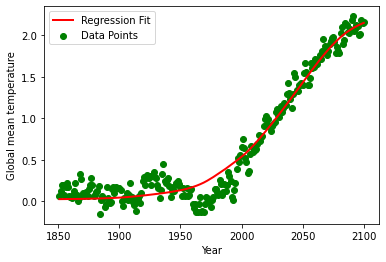

In [13]:
year = df['year'].values.reshape(-1,1)

#plotting the data
plt.scatter(year,y, label = 'Data Points',color = 'green')
plt.plot(year, predict, label = 'Regression Fit', color = 'Red', linewidth = 2.0)
plt.xlabel('Year')
plt.ylabel('Global mean temperature')
plt.legend(loc = 'best')
plt.show()

Where does the prediction do well? Where does it do less well? Visualise the residuals.

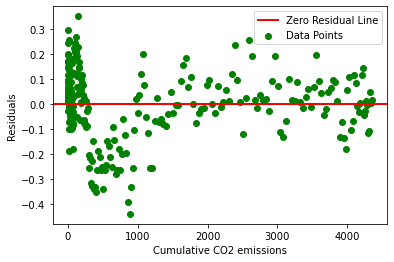

In [14]:
# Calculate residuals by subtracting predicted values from actual values
residuals = y-predict

#plotting the data
plt.scatter(X,residuals, label = 'Data Points',color = 'green')
plt.axhline(y=0, color='red', label='Zero Residual Line', linewidth = 2.0)
plt.xlabel('Cumulative CO2 emissions')
plt.ylabel('Residuals')
plt.legend(loc = 'best')
plt.show()

## 4. Extend this to a regional temperature model, by region, and by state

While the relationship between global temperature and cumulative CO2 emissions is very linear, the relationship between regional temperature and cumulative CO2 emissions is less so. This is because the regional temperature is affected by other factors, such as the regional distribution of land and ocean, and the regional distribution of CO2 emissions. Nevertheless, let's see how well it can do

Read in the country mask which is a 2D array of the same size as the temperature data, with each grid cell containing the country code of the country that grid cell is in.

In [15]:
country_mask_file = 'country_mask.nc'

#reading the NetCDF file
country_mask = xr.open_dataarray(country_mask_file)
country_mask

<xarray.DataArray (lat: 96, lon: 144)>
[13824 values with dtype=<U24]
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

Average the spatial coordinates into countries so that you end up with a dataset that has dimensionality of the number of countries by the number of time points.

In [16]:
temperature_data = xr.open_dataset('global_temparature.nc')

# Assigning coordinates to the 'country' dimension based on the country mask data
temperature_data = temperature_data.assign_coords(country=((['lat','lon']),country_mask.data))
# Grouping the temperature data by the 'country' dimension and calculating the mean
global_temp = temperature_data.groupby('country').mean()
global_temp

<xarray.Dataset>
Dimensions:   (time: 250, country: 150)
Coordinates:
  * time      (time) int64 1851 1852 1853 1854 1855 ... 2096 2097 2098 2099 2100
    quantile  float64 0.9
  * country   (country) object 'Afghanistan' 'Albania' ... 'Zambia' 'Zimbabwe'
Data variables:
    tas       (country, time) float32 0.3524 0.2306 0.5797 ... 3.522 3.409 3.674

Plot a bar chart of the warming in each country in 2023. Note, the temperature data is baselined to 1850.

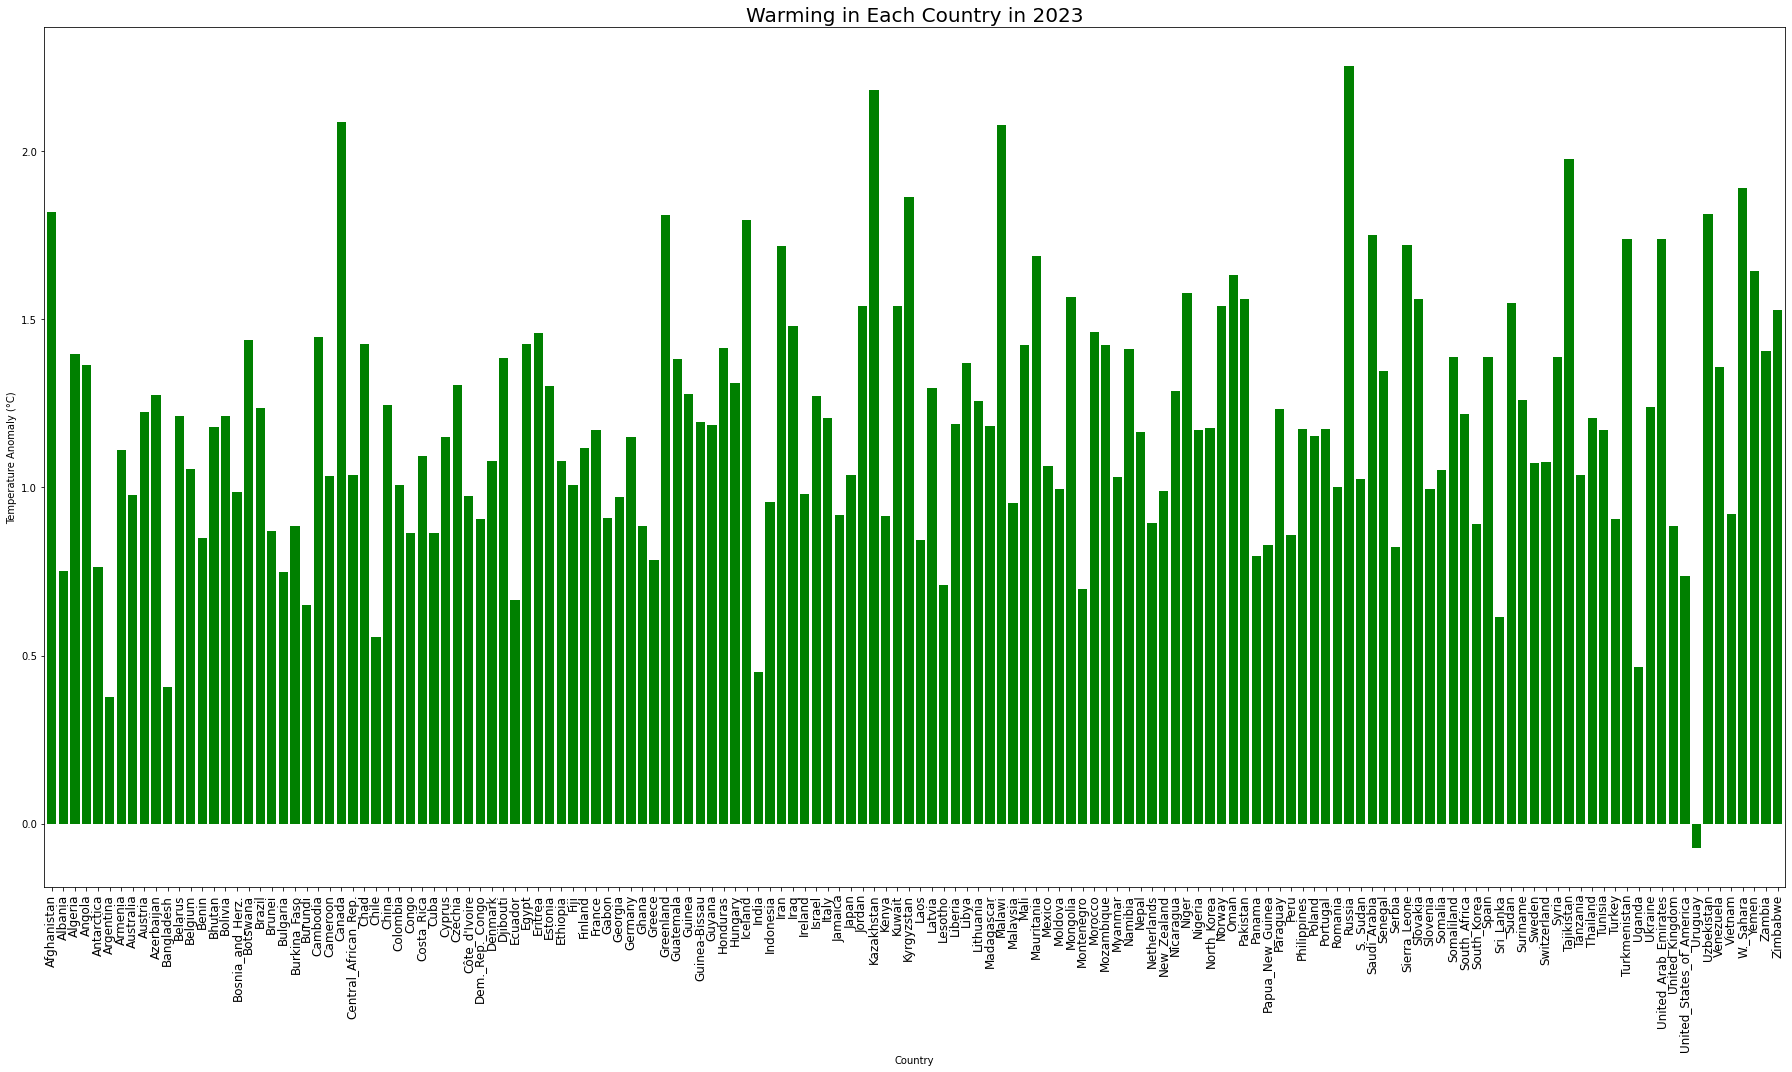

In [17]:
data_2023 = global_temp['tas'].sel(time=2023)

# Convert to a pandas Series
series_2023 = data_2023.to_series()

# Set the figure size
plt.figure(figsize=(25, 15))

# Create the bar chart
xa = series_2023.plot.bar(width=0.8, color ='green')

# Set the title and labels
xa.set_title('Warming in Each Country in 2023', fontsize = 20)
xa.set_xlabel('Country')
xa.set_ylabel('Temperature Anomaly (°C)')

# Rotate x-axis labels
xa.set_xticklabels(series_2023.index, rotation=90, ha='center', fontsize=12)

# Ensure all x-axis labels are shown
plt.xticks(range(len(series_2023.index)), series_2023.index)

# Ensure layout fits the plot and labels
plt.tight_layout()

# Display the plot
plt.show()

Calculate a linear regression model for each country along with the R^2 value. Plot the R^2 values for each country as a bar chart.

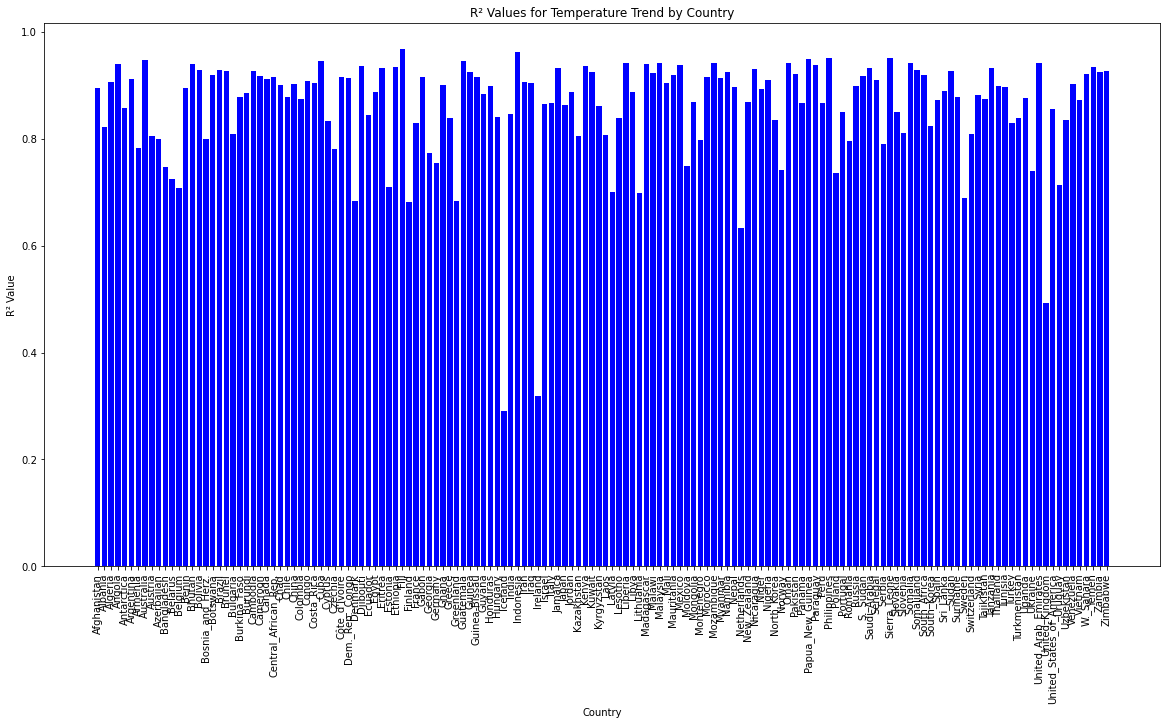

In [18]:
r2 = {}

# Iterate over each country
for country in global_temp['tas'].country.values:
    temp_timeseries = global_temp['tas'].sel(country=country)
    
    # Prepare the data for fitting the model (X should be 2D array, y should be 1D array)
    X = df['cumulative_global_total'].values.reshape(-1, 1)  # Time as 2D array
    y = temp_timeseries.values  # Temperature as 1D array
    
    # Fitting the linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    r2[country] = model.score(X, y)

# Convert the R^2 values to list format
countries = list(r2.keys())
r2_scores = list(r2.values())

# Plotting the R^2 values
plt.figure(figsize=(20, 10))
plt.bar(countries, r2_scores, color='blue')
plt.xlabel('Country')
plt.ylabel('R² Value')
plt.title('R² Values for Temperature Trend by Country')
plt.xticks(rotation=90)  # Rotate the x-axis labels for readability
plt.show()

For which countries does the linear assumption work well, and where does it work less well?

Countries exhibiting tall bars nearing an R² value of 1 on the chart adhere closely to the linear model assumption, indicating that temperature changes over time align well with a linear function. In contrast, nations with shorter bars, particularly those with R² values significantly below 1 and closer to 0, suggest that the linear assumption fails to capture the intricacies and fluctuations in temperature changes over time. This discrepancy may stem from diverse climate patterns, varied geographical and topographical features, or other localized factors not accommodated by a simplistic linear model.

(1) Elevated R² values (e.g., surpassing 0.7): The linear assumption holds effectively, signifying that the temperature trend can be accurately represented by a linear model. Examples include Afghanistan and Zimbabwe.

(2) Depressed R² values (e.g., falling below 0.3): The linear assumption is less applicable, implying greater variability in temperature trends influenced by non-linear factors over time. Examples encompass Iceland, Ireland, and European countries in general.

## 5. Plot the regression coefficients for each country


Which five countries are most sensitive to CO2 emissions and hence warming the fastest?

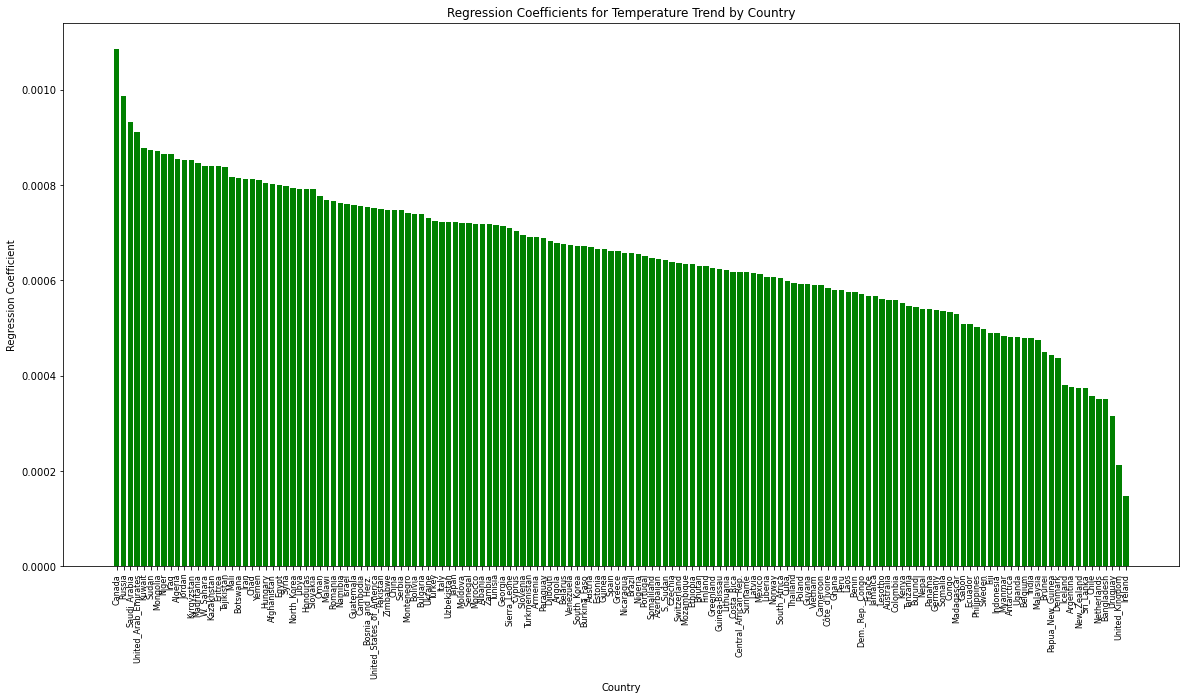

The 5 countries which are most sensitive to CO2 emissions are:  ['Canada', 'Russia', 'Saudi_Arabia', 'United_Arab_Emirates', 'Kuwait']


In [19]:
coefficients = {}

# Iterate over each country to compute the regression coefficients
for country in global_temp['tas'].country.values:
    X = df['cumulative_global_total'].values.reshape(-1, 1)  # Time as a 2D array for the regression model
    y = global_temp['tas'].sel(country=country).values  # Temperature data

    # Fitting the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Store the coefficient for the country
    coefficients[country] = model.coef_[0]
    
# Plot the coefficients
countries = list(coefficients.keys())
coeffs = list(coefficients.values())

# Sort the countries by the absolute value of their coefficients, descending
sorted_countries = sorted(countries, key=lambda x: abs(coefficients[x]), reverse=True)

# Sort the coefficients according to the sorted countries
sorted_coeffs = [coefficients[country] for country in sorted_countries]

# Plotting the coefficients
plt.figure(figsize=(20, 10))
plt.bar(sorted_countries, sorted_coeffs, color='green')
plt.xlabel('Country')
plt.ylabel('Regression Coefficient')
plt.title('Regression Coefficients for Temperature Trend by Country')
plt.xticks(rotation=90, fontsize=8)
plt.show()

# Identify the five countries with the largest absolute coefficients
top_five_countries = sorted_countries[:5]
print("The 5 countries which are most sensitive to CO2 emissions are: ", top_five_countries)

## 6. Do an analysis of your choosing

Maybe dig into the changes in one particular country, or look at changes in the variability of temperature. Perhaps look at the chances of exceeding certian temperature limits. 

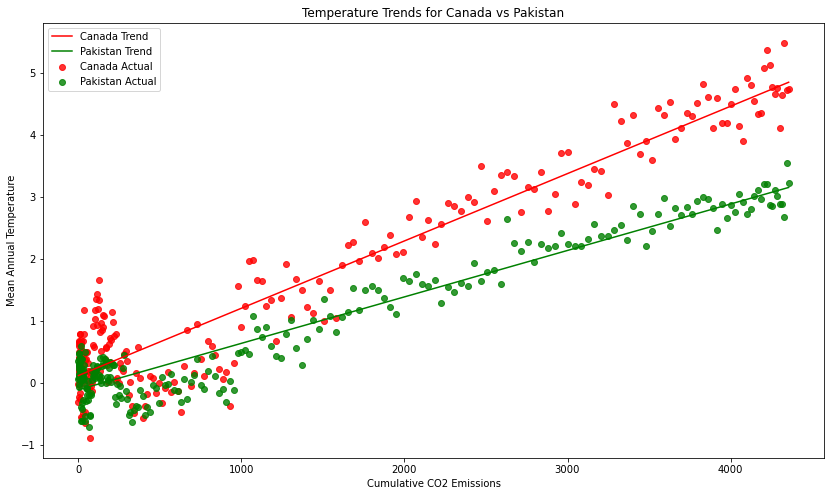

Standard Deviation of Annual Temperature for Canada: 1.6591637134552002
Standard Deviation of Annual Temperature for Pakistan: 1.1386158466339111
Temperature trend (slope) for Canada: 0.0010866378859765902
Temperature trend (slope) for Pakistan: 0.0007495032352024733


In [37]:
country1 = 'Canada'
country2 = 'Pakistan'

# Calculate annual mean temperatures for each country over all dimensions
annual_mean_temp_country1 = global_temp['tas'].sel(country=country1).groupby('time').mean(...)
annual_mean_temp_country2 = global_temp['tas'].sel(country=country2).groupby('time').mean(...)

# Prepare the data for regression models
cumulative_emissions = pd.read_csv('combinedcumulative_CO2.csv')['cumulative_global_total']
X = cumulative_emissions.values

# Temperature trends using linear regression
coeff_country1 = np.polyfit(X.flatten(), annual_mean_temp_country1.values, 1)
coeff_country2 = np.polyfit(X.flatten(), annual_mean_temp_country2.values, 1)

# Calculate the standard deviation which shows temperature variability
sdcn1 = annual_mean_temp_country1.std(dim='time')
sdcn2 = annual_mean_temp_country2.std(dim='time')

# Plotting the trends
plt.figure(figsize=(14, 8))
plt.plot(cumulative_emissions.values, np.polyval(coeff_country1, X.flatten()), label=f'{country1} Trend', color='red')
plt.plot(cumulative_emissions.values, np.polyval(coeff_country2, X.flatten()), label=f'{country2} Trend', color='green')
plt.scatter(cumulative_emissions.values, annual_mean_temp_country1, label=f'{country1} Actual', alpha=0.8, color='red')
plt.scatter(cumulative_emissions.values, annual_mean_temp_country2, label=f'{country2} Actual', alpha=0.8, color='green')
plt.xlabel('Cumulative CO2 Emissions')
plt.ylabel('Mean Annual Temperature')
plt.title('Temperature Trends for Canada vs Pakistan')
plt.legend()
plt.show()

# Print out the variability for both countries
print(f"Standard Deviation of Annual Temperature for {country1}: {sdcn1.values}")
print(f"Standard Deviation of Annual Temperature for {country2}: {sdcn2.values}")

# Print out the slope (temperature trend) for both countries
print(f"Temperature trend (slope) for {country1}: {coeff_country1[0]}")
print(f"Temperature trend (slope) for {country2}: {coeff_country2[0]}")

# Inference:

The scatter plot shows that both Canada and Pakistan are warming, but that Canada is warming faster.
This is likely due to a combination of factors, including latitude, landmass, and land cover.

## 7. Make a command line interface to a prediction script 

The inputs should include the name of a country (or global mean) and CO2 concentration(s). It should return the predicted temperature change relative to 1850. You can use the `argparse` package to do this. See [here](https://docs.python.org/3/howto/argparse.html) for documentation. Be sure to check for valid inputs.

Also provide the option to save the predictions to a CSV file.

This script should use the regression coefficients learned in the previous step so it doesn't have to use the full model output each time. You could store them in a numpy file, a pandas CSV file, or even JSON. 

In [33]:
#creating a pandas dataframe from the sorted countries and respective sorted coeffiecients to save as csv for the .py for CLI
sorted_list = list(zip(sorted_countries, sorted_coeffs))
sorted_df = pd.DataFrame(sorted_list, columns = ['country', 'coefficients'])
sorted_df.to_csv('Regression_Coeffecient.csv')

In [22]:
#FOLLOIWING IS THE CLI.PY CODE BLOCK


##### import argparse
import pandas as pd
import argparse

df1 = pd.read_csv('Regression_coefficients.csv')


def create_parser():
    parser = argparse.ArgumentParser(description="Predict temperature change based on country and CO2 concentration.")
    parser.add_argument("country", type=str, help="Name of the country")
    parser.add_argument("co2_concentration", type=float, help="CO2 concentration level")
    parser.add_argument("--save_csv", action="store_true", help="Option to save the predictions to a CSV file")
 
    return parser

# Function to perform the prediction
def predict_temperature_change(df1, country, co2_concentration):
    if country not in df1['country'].values:
        return "Country not found in the dataframe."
    else:
        coeff = df1.loc[df1['country'] == country, 'coefficients'].iloc[0]
        return coeff * co2_concentration

# Main function to parse arguments and execute the prediction
def main(args=None):
    flag = True
    parser = create_parser()
    
    args = parser.parse_args(args)
    try:
        prediction = predict_temperature_change(df1, args.country, args.co2_concentration)
        if (prediction == "Country not found in the dataframe."):
            print(prediction)
            flag = False
        else:
            
            print(f"The predicted temperature change for {args.country} with a CO2 concentration of {args.co2_concentration} is {prediction}")
    except ValueError as e:
        print(e)
        
    if flag and args.save_csv:
        predictions_df = pd.DataFrame({'Country': [args.country], 'CO2 Concentration': [args.co2_concentration], 'Predicted Temperature Change': [prediction]})
        predictions_df.to_csv('/home/a1jadhav/FinalProject/predictions.csv', index=False)
        print("Predictions saved to predictions.csv")

# Finally calling the main function to execute the script
main()

usage: ipykernel_launcher.py [-h] [--save_csv] country co2_concentration
ipykernel_launcher.py: error: the following arguments are required: co2_concentration


SystemExit: 2

In [34]:
#running the command by testing for country 'Malawi' with random Co2 concentration 650
!python CLI.py Malawi 650 --save_csv

The predicted temperature change for Malawi with a CO2 concentration of 650.0 is 0.500125040825215
Predictions saved to predictions.csv


In [35]:
#Checking the output
saved_file = pd.read_csv('predictions.csv')
saved_file

,Country,CO2 Concentration,Predicted Temperature Change
0,Malawi,650.0,0.500125
